### Example Data Exploration and Successful Segmentation with PCA

### Background:

The following dataset contains 1m rows of http response data from a web crawler, with the following schema:

- hostnameHash - this is a hash of the hostname of the http request url.
- parentPageGuid - the unique ID of the parent page of this request (more explanation on this below).
- pageGuid - this is a unique ID assigned to the http response received
- httpResponseCode - the http response code received
- responseBodyMD5 - the md5 hash of the response body received
- responseBodySize - the size, in bytes, of the response body
- contentType - the contents of the content type header

In this web crawler, every http response is assigned a unique ID.  If a http response loads dependent requests (e.g., if we make a request to http://www.google.com, the response may include an additional request/response from https://www.google.com/images/nav_logo242.png) then those dependent requests will be assigned a parent page guid that matches the guid of the calling page.  If the parentPageGuid field is null, that means that the corresponding response came from a direct request (i.e., not loaded from some other page).  If the hostnameHash field is null, that means that we were unable to parse the url for some unknown reason.

Goal: to understand more about these hosts and their dependent requests.  What can we derive from this data?  Some ideas:

* what does the distribution of dependent requests across hosts look like?  What other basic statistics might be interesting to describe this data?
* can you classify hosts into reasonable "types" based on these features?  Conceivably, www.google.com will look different from www.nytimes.com, but perhaps www.google.com and www.bing.com are similar?
* are there interesting correlations between dependent requests?
* any other interesting question you might want to answer...



### Importing libraries:

In [1]:
import numpy as np
import pandas as pd
from time import time
import scipy.stats as stats

from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# helper functions for data exploration/DS/ML pipelines
from lucky_bucket import *

### Reading in data:



In [9]:

col_names=['hostnameHash','parentPageGuid','pageGuid','httpResponseCode',\
           'responseBodyMD5','responseBodySize','contentType']
data_df=pd.read_csv(r'rb_md5s.txt',sep='\t',names=col_names) 

In [10]:
data_df.head()

,hostnameHash,parentPageGuid,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
0,7905d1c4e12c54933a44d19fcd5f9356,NaN,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,200,bb7dd71b8d8c490749255da6b3aaa22b,252182.0,text/html
1,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
2,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b80e939c-ec86-4ba0-a21b-a05f47d11f69,302,07b4511278d33e0a152458bc56121059,128.0,text/html
3,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,14d39101-c2ac-46bc-bde9-fbb5822fc41c,200,d681413ffee243c992957f487973ad36,13381.0,text/javascript
4,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,d9ad296b-5ea3-4964-bd15-e9e5fe52b873,200,687707a77e06dbaecaaa688f8485bad1,561539.0,application/javascript


### Data exploration:

#### Explore data:

In [11]:
# explore data

exp1(data_df)

rows and columns: (1000000, 7)

data types and columns in data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
hostnameHash        986331 non-null object
parentPageGuid      979613 non-null object
pageGuid            1000000 non-null object
httpResponseCode    1000000 non-null int64
responseBodyMD5     998727 non-null object
responseBodySize    814721 non-null float64
contentType         952772 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 53.4+ MB


None


unique values in each column:


hostnameHash          15572
parentPageGuid        45068
pageGuid            1000000
httpResponseCode         56
responseBodyMD5      299222
responseBodySize      82611
contentType             142
dtype: int64


percentage duplicates : 0.0

Percentage of column with missing values:



hostnameHash        0.013669
parentPageGuid      0.020387
pageGuid            0.000000
httpResponseCode    0.000000
responseBodyMD5     0.001273
responseBodySize    0.185279
contentType         0.047228
dtype: float64


Data snapshot:

                       hostnameHash                        parentPageGuid  \
0  7905d1c4e12c54933a44d19fcd5f9356                                   NaN   
1  7905d1c4e12c54933a44d19fcd5f9356  1a6c0d62-b3b6-4bb2-aaed-f389f7771d60   
2  7905d1c4e12c54933a44d19fcd5f9356  1a6c0d62-b3b6-4bb2-aaed-f389f7771d60   
3  7905d1c4e12c54933a44d19fcd5f9356  1a6c0d62-b3b6-4bb2-aaed-f389f7771d60   
4  131a460e5e56b32eb51e09395cb62074  1a6c0d62-b3b6-4bb2-aaed-f389f7771d60   

                               pageGuid  httpResponseCode  \
0  1a6c0d62-b3b6-4bb2-aaed-f389f7771d60               200   
1  e998b51a-e117-4e28-8bc2-f3aa52b6cca9               301   
2  b80e939c-ec86-4ba0-a21b-a05f47d11f69               302   
3  14d39101-c2ac-46bc-bde9-fbb5822fc41c               200   
4  d9ad296b-5ea3-4964-bd15-e9e5fe52b873               200   

                    responseBodyMD5  responseBodySize             contentType  
0  bb7dd71b8d8c490749255da6b3aaa22b          252182.0               text/

### Observations:

Possible field types:

- Id:
    - hostnameHash
    - parentPageGuid
    - pageGuid
    - responseBodyMD5
- Continuous:
    - responseBodySize
- Categorical
    - httpResponseCode
    - contentType
    
Notes:
- there are no duplicate records
- fields are mostly filled except responseBodySize which is missing nearly 20% of time
- pageGuid is unique for every record
- httpResponseCode can be grouped into:
    - 100s Informational
    - 200s Success
    - 300s Redirection
    - 400s Client Error
- if parentPageGuid is NaN then it is not a dependent request
- hostnameHash is missing in about 1.4% indicating url couldn't be parsed


### Distribution of dependent requests:

#### preproccess data:

In [14]:
# preproccess data

depend_df=data_df.copy()

# dropping records where url couldn't be parsed 
# filtering for only dependent requests
# Note: Assumption if parentGuid is missing and hostnameHash isn't then it's not a dependent request
depend_df=depend_df.dropna(subset=['hostnameHash','pageGuid'])


(986331, 7)

#### httpResponseCode:

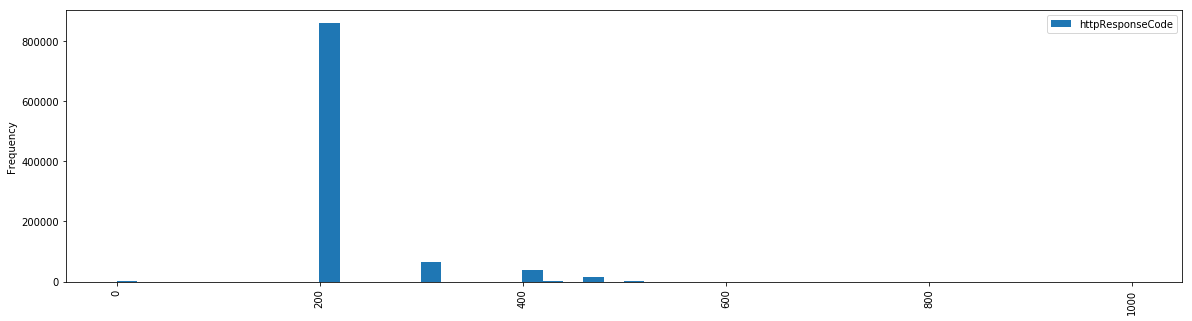

In [21]:
# httpResponseCode

depend_df[['httpResponseCode']].plot(figsize=(20,5),kind='hist',rot=90,bins=50)

#### Observation:
- Majority of dependent requests response codes are of type "Success"

#### contentType:

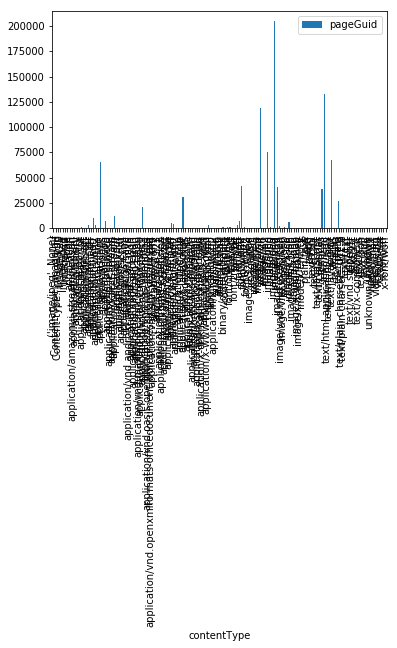

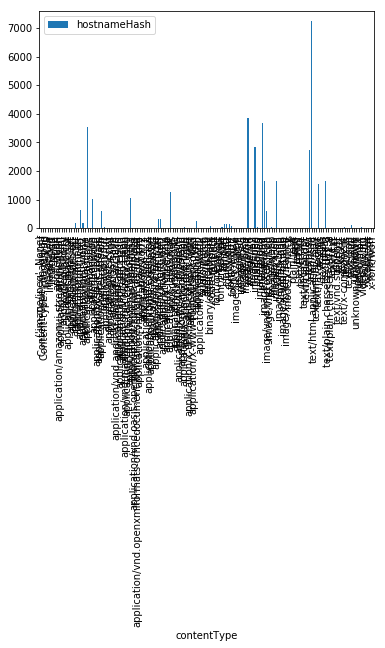

In [31]:
# contentType

# depend_df[['contentType']].plot(figsize=(20,5),kind='hist',rot=90)

id_plot(ca_col2=['contentType'], i_col2=['pageGuid','hostnameHash'], d_df2=depend_df)

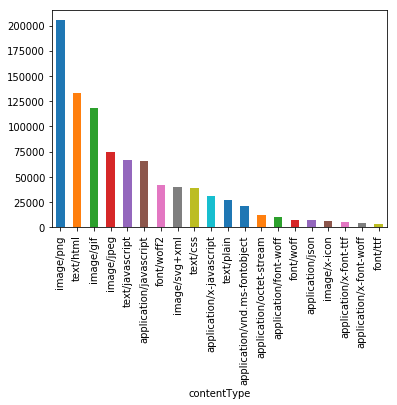

In [34]:
type_df=depend_df.groupby('contentType')['pageGuid'].nunique().sort_values(ascending=False)

type_df[:20].plot(kind='bar')

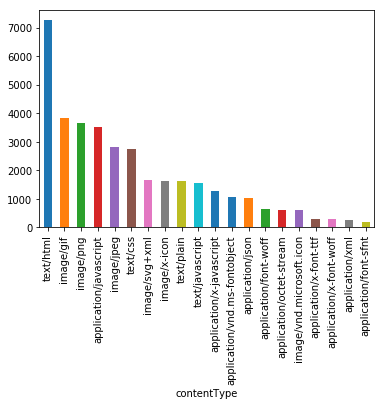

In [35]:
type_df2=depend_df.groupby('contentType')['hostnameHash'].nunique().sort_values(ascending=False)

type_df2[:20].plot(kind='bar')

#### Observation:
- Majority of dependent requests have about 15 contentTypes

#### responseBodySize: 

In [40]:
depend_df[['responseBodySize']].describe()

,responseBodySize
count,8.064850e+05
mean,3.805323e+04
std,1.713338e+05
min,1.000000e+00
25%,5.610000e+02
50%,4.092000e+03
75%,2.438000e+04
max,1.048576e+07


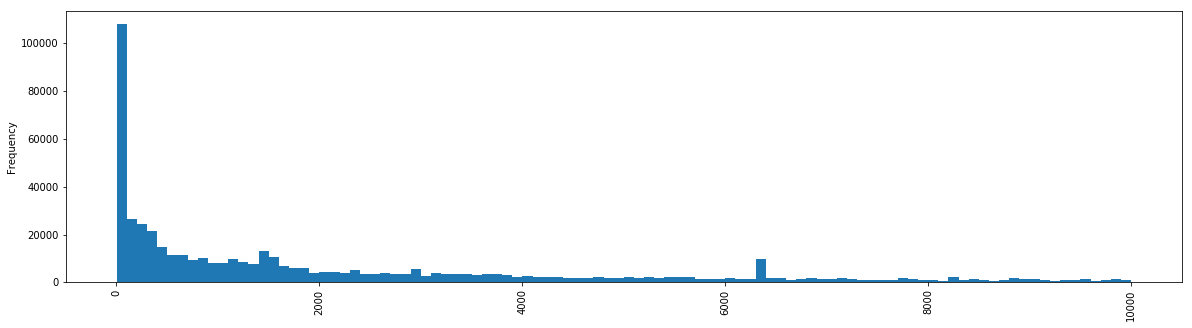

In [45]:
depend_df[depend_df['responseBodySize']<10000].responseBodySize.plot(figsize=(20,5),kind='hist',rot=90,bins=100)

#### Observation:
- Majority of dependent requests have responseBodySize below 2000, with some extreme outliers

#### PageGuid and responseBodyMD5 by hostnameHash

In [49]:
# dependent requests by host

idcnt_df=depend_df.groupby('hostnameHash').agg({'pageGuid':'nunique','responseBodyMD5':'nunique'})
idcnt_df.describe()

,pageGuid,responseBodyMD5
count,15572.000000,15572.00000
mean,63.340033,22.73401
std,597.006215,138.13045
min,1.000000,0.00000
25%,1.000000,1.00000
50%,3.000000,2.00000
75%,17.000000,7.00000
max,46514.000000,8448.00000


#### Observation:
- Majority of dependent requests have less than 20 distinct pageGuid, with significant variation and outliers
- Majority of dependent requests have less than 10 distinct responseBodyMD5, with significant variation and outliers

### Correlation:
- dependent requests

#### Correlation between categorical and continuous variables

In [54]:

catLst=['httpResponseCode','contentType']
contLst=['responseBodySize']

catConCorDct(datDf=depend_df,CtLst=catLst,CntLst=contLst)

/Users/sshields/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 54, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/Users/sshields/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 141, but rank is 134
  'rank is %d' % (J, J_), ValueWarning)


{'httpResponseCode': [], 'contentType': ['responseBodySize']}

#### Observation:
- contentType is correlated with responseBodySize
- httpResonseCode is not correlated with responseBodySize

### Segmentation:
Simplifying data for take home
- filtering for only success httpResponseCode
- filter for top 20 contentType

In [59]:
# filtering data

TopCTypLst=type_df2[:20].index.tolist()

simp_df=depend_df[(depend_df['contentType'].isin(TopCTypLst))\
                  &((depend_df['httpResponseCode']>199)\
                    &(depend_df['httpResponseCode']<201))]

simp_df.shape

(770359, 7)

In [70]:
# aggregating by hostnameHash

agg_df=simp_df.copy()
agg_df=simp_df.pivot_table(values='responseBodyMD5', index='hostnameHash', columns='contentType',\
                           aggfunc=pd.Series.nunique)


PageSize_df=simp_df.copy()
PageSize_df=PageSize_df.groupby('hostnameHash').agg({'pageGuid':'nunique','responseBodySize':'mean'})

merge_df=pd.merge(agg_df,PageSize_df,how='inner',left_on=['hostnameHash'],right_on=['hostnameHash'])

merge_df=merge_df.fillna(0)

merge_df.head()

,application/font-sfnt,application/font-woff,application/javascript,application/json,application/octet-stream,application/vnd.ms-fontobject,application/x-font-ttf,application/x-font-woff,application/x-javascript,application/xml,...,image/png,image/svg+xml,image/vnd.microsoft.icon,image/x-icon,text/css,text/html,text/javascript,text/plain,pageGuid,responseBodySize
hostnameHash,,,,,,,,,,,,,,,,,,,,,
000758a353fa674f968ab5d837170129,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,14,87430.166667
0007f9134e2994a9622699faa03fb446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,43.000000
000e7c78f3f74a9a932d54887cc6bb4f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,43.000000
001d74bb3f28aaed078c549b35420d03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5,303.000000
001dcc1adf7693e8639d1d8132b77a90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,43.000000


/Users/sshields/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,application/font-sfnt,application/font-woff,application/javascript,application/json,application/octet-stream,application/vnd.ms-fontobject,application/x-font-ttf,application/x-font-woff,application/x-javascript,application/xml,...,image/png,image/svg+xml,image/vnd.microsoft.icon,image/x-icon,text/css,text/html,text/javascript,text/plain,pageGuid,responseBodySize
application/font-sfnt,1.000000,0.350030,0.017169,0.006137,0.010707,0.391453,0.047514,-0.002928,0.019521,0.006587,...,0.144922,0.158074,0.132802,0.015810,0.036454,0.000372,-0.002445,-0.006482,0.119267,0.015140
application/font-woff,0.350030,1.000000,0.029221,0.003647,0.047167,0.434482,0.122372,-0.001863,0.012978,0.005154,...,0.096675,0.119842,0.054303,0.044375,0.045469,0.005174,0.011278,0.011135,0.090785,0.012621
application/javascript,0.017169,0.029221,1.000000,0.034575,0.029213,0.073249,0.033656,0.026046,-0.002435,0.065543,...,0.068240,0.038957,0.040402,0.023496,0.048173,0.025954,-0.002117,0.004623,0.148951,0.003747
application/json,0.006137,0.003647,0.034575,1.000000,0.003429,0.008263,-0.000941,0.004331,0.000064,-0.000924,...,0.006661,0.005448,-0.001351,0.010762,0.001093,0.059642,0.240902,0.000182,0.108502,-0.008160
application/octet-stream,0.010707,0.047167,0.029213,0.003429,1.000000,0.105677,0.039189,0.041950,0.020865,0.010571,...,0.060273,0.096455,0.000427,0.034727,0.024042,0.012685,0.004234,-0.001280,0.057429,0.007179
application/vnd.ms-fontobject,0.391453,0.434482,0.073249,0.008263,0.105677,1.000000,0.647935,0.570173,0.028961,-0.000282,...,0.213635,0.255857,0.187887,0.104937,0.091358,0.000242,0.004030,0.154856,0.158343,0.032947
application/x-font-ttf,0.047514,0.122372,0.033656,-0.000941,0.039189,0.647935,1.000000,0.705904,0.012595,0.007764,...,0.063082,0.178446,0.061196,0.066517,0.035180,0.010422,-0.000548,0.035302,0.095650,0.029376
application/x-font-woff,-0.002928,-0.001863,0.026046,0.004331,0.041950,0.570173,0.705904,1.000000,0.032395,-0.002047,...,0.071141,0.139496,0.084904,0.051298,0.025108,0.002249,0.002894,0.020369,0.080770,0.021257
application/x-javascript,0.019521,0.012978,-0.002435,0.000064,0.020865,0.028961,0.012595,0.032395,1.000000,0.002845,...,0.099831,0.023020,-0.007917,0.033488,0.043256,0.009453,0.009738,0.020397,0.151612,0.002017
application/xml,0.006587,0.005154,0.065543,-0.000924,0.010571,-0.000282,0.007764,-0.002047,0.002845,1.000000,...,0.019191,0.013966,0.001347,0.009535,0.003257,0.869405,0.000565,-0.002111,0.169928,-0.004079


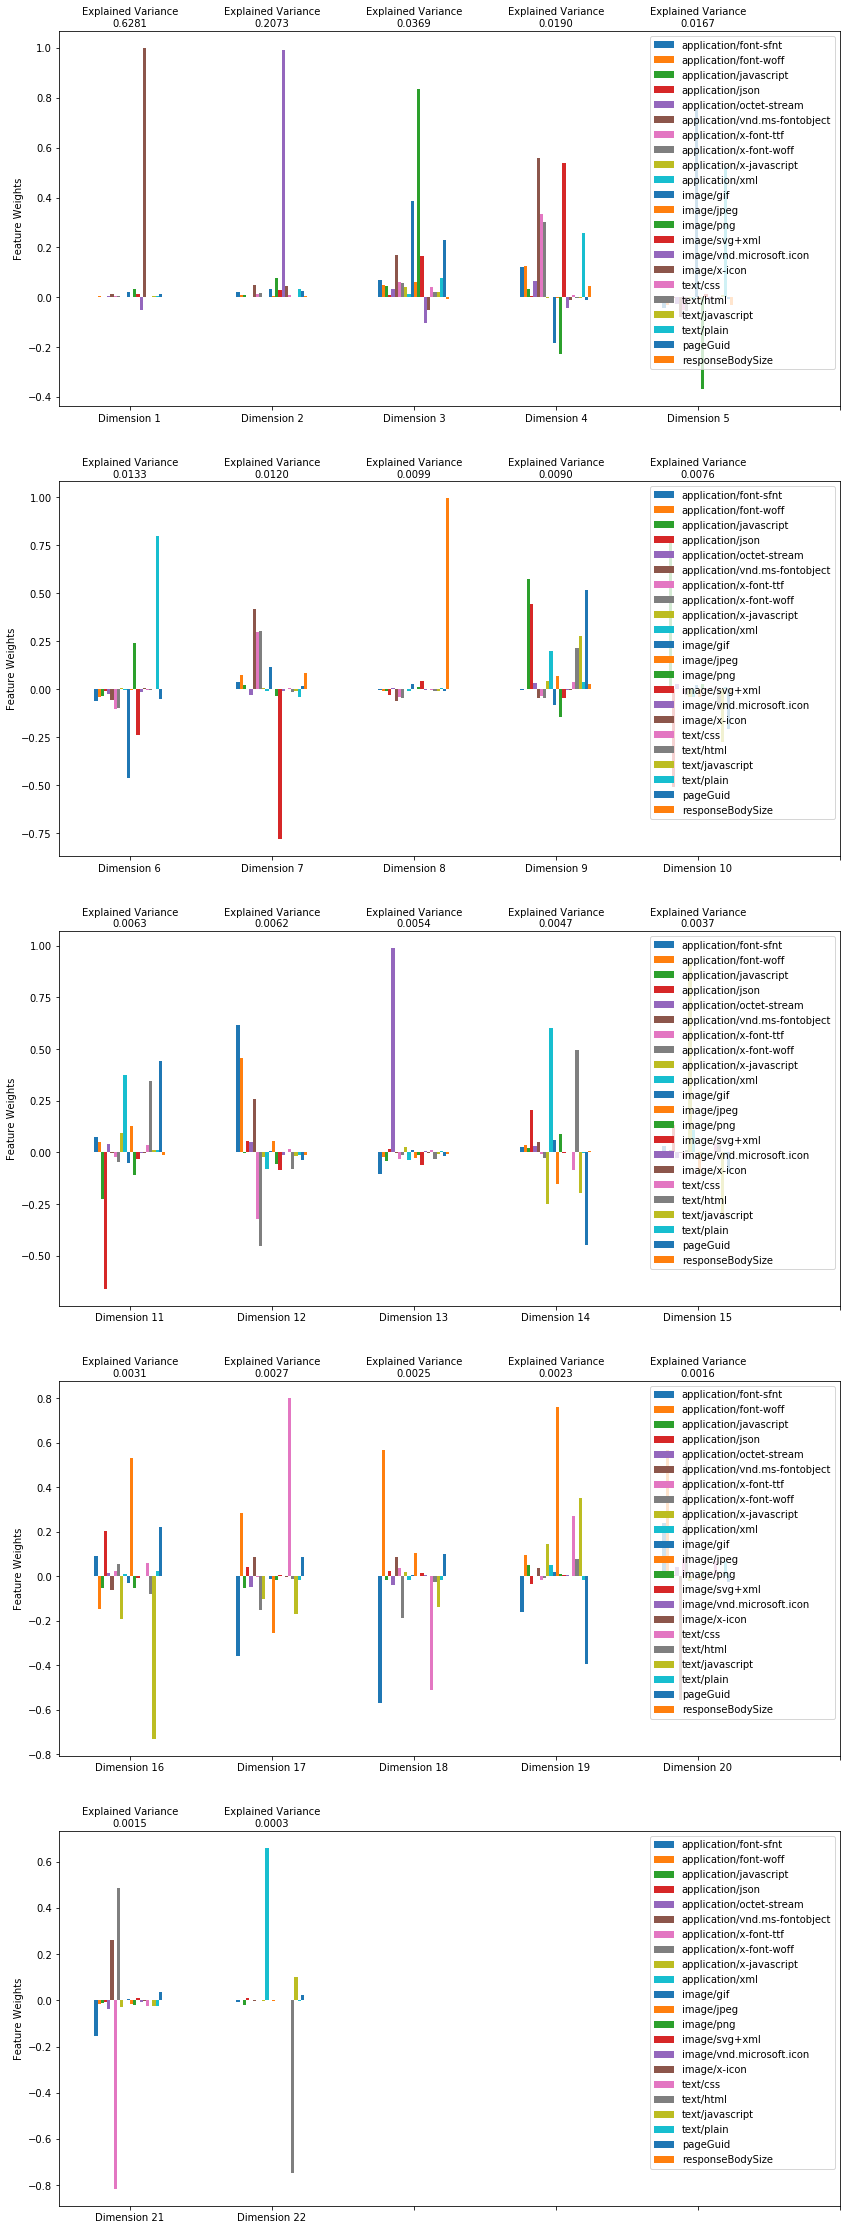

For n_clusters = 2. The average silhouette_score is : 0.8206229960277177
For n_clusters = 3. The average silhouette_score is : 0.8687445148311178
For n_clusters = 4. The average silhouette_score is : 0.8831574315741962
For n_clusters = 5. The average silhouette_score is : 0.8868751468693218
For n_clusters = 6. The average silhouette_score is : 0.8908041393539063
For n_clusters = 7. The average silhouette_score is : 0.8889127322538565
For n_clusters = 8. The average silhouette_score is : 0.8900522528235069
For n_clusters = 9. The average silhouette_score is : 0.8910785439601823
For n_clusters = 10. The average silhouette_score is : 0.8919060054902177
For n_clusters = 11. The average silhouette_score is : 0.8915152929822803
For n_clusters = 12. The average silhouette_score is : 0.8925113634743509
For n_clusters = 13. The average silhouette_score is : 0.8906883974876239
For n_clusters = 14. The average silhouette_score is : 0.8935510541544621
For n_clusters = 15. The average silhouette_sc

In [72]:
# Exploring correlation, PCA, Clustering

scalePcaCluster(spc_df=merge_df,numList=merge_df.columns)

### Observation:

- First two components from PCA explain over 80% of variance in data
- 16 clusters has highest silhouette score, but not significantly higher than most
- no signs of correlation between average responseBodySize, number of pageGuid, and counts of contentType
- Note: results of PCA and Silhouette scores indicate data can be segmented

#### Performing Segmentation
- Dimensionality reduction using first two components from PCA
- clustering with K-means on reduced dimensions

In [74]:
# Apply MinMax scaler to data
scaled_data=scaleData(s_df=merge_df,list_cont=merge_df.columns)

In [75]:
# Dimensionality reduction using PCA
# Express data in terms of first two components from PCA

from sklearn.decomposition import PCA

good_data=scaled_data

# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data1 = pca.transform(good_data)

# Create a DataFrame for the reduced data
reduced_data1 = pd.DataFrame(reduced_data1, columns = ['Dimensnion_1',
 'Dimensnion_2'])#colList)

In [94]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Loop through clusters
for n_clusters in range(2,16):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data1)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data1)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    # sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data1, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.8918840686783409
For n_clusters = 3. The average silhouette_score is : 0.955201802651279
For n_clusters = 4. The average silhouette_score is : 0.9838020108777874
For n_clusters = 5. The average silhouette_score is : 0.9896474586477252
For n_clusters = 6. The average silhouette_score is : 0.9920548082469768
For n_clusters = 7. The average silhouette_score is : 0.9930500095430341
For n_clusters = 8. The average silhouette_score is : 0.9933330031495714
For n_clusters = 9. The average silhouette_score is : 0.9933535326471032
For n_clusters = 10. The average silhouette_score is : 0.9933979043898831
For n_clusters = 11. The average silhouette_score is : 0.9934799387460678
For n_clusters = 12. The average silhouette_score is : 0.9566257623597972
For n_clusters = 13. The average silhouette_score is : 0.9567359527519351
For n_clusters = 14. The average silhouette_score is : 0.9338409690446421
For n_clusters = 15. The average silhouette_sco

#### Observation:
- 11 clusters has highest silhouette score, but not significantly higher than most

In [121]:
# K-means with specific number of clusters

# tried
# clusters = 11
# clusters = 6
# clusters = 4
clusterer = KMeans(n_clusters=6).fit(reduced_data1)
preds = clusterer.predict(reduced_data1)
centers = clusterer.cluster_centers_

In [122]:
# checking number in each cluster

clustered_data=reduced_data1.copy()
clustered_data['Cluster']=preds
clustered_data.groupby('Cluster').count()

,Dimensnion_1,Dimensnion_2
Cluster,,
0,1323,1323
1,10002,10002
2,528,528
3,300,300
4,56,56
5,19,19


#### Observation:
- Some clusters have very few members.  A lower number of clusters may be more useful.

In [123]:
pd.set_option('display.max_columns', 22)

# TODO: Inverse transform the centers
centers2 = pca.inverse_transform(centers)



# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers2))]
#true_centers = pd.DataFrame(np.round(centers2), columns = scaled_data.keys())
true_centers = pd.DataFrame(centers2, columns = scaled_data.keys())
true_centers.index = segments
display(true_centers)

# adding original data for easy comparison

display(scaled_data.describe())

,application/font-sfnt,application/font-woff,application/javascript,application/json,application/octet-stream,application/vnd.ms-fontobject,application/x-font-ttf,application/x-font-woff,application/x-javascript,application/xml,image/gif,image/jpeg,image/png,image/svg+xml,image/vnd.microsoft.icon,image/x-icon,text/css,text/html,text/javascript,text/plain,pageGuid,responseBodySize
Segment 0,0.001080,0.001790,0.002619,0.001351,0.001975,0.006980,0.002757,0.002401,0.001521,0.000459,0.010177,0.001152,0.016839,0.006755,0.000008,0.333294,0.001650,0.001091,0.001582,0.003102,0.006188,0.004787
Segment 1,0.000295,0.000522,0.001563,0.000956,0.000831,0.001500,0.000467,0.000502,0.000614,0.000210,0.002310,0.000424,0.003892,0.001483,0.000057,0.000033,0.000538,0.000166,0.000328,0.001314,0.000973,0.004649
Segment 2,0.007547,0.003480,0.004700,0.000973,0.001207,0.018383,0.004745,0.006049,0.000572,0.000360,0.013740,0.001582,0.028589,0.010502,0.332478,-0.000473,0.003225,0.000417,0.000746,0.012341,0.009192,0.005853
Segment 3,0.001883,0.003095,0.003703,0.001758,0.003153,0.012612,0.005112,0.004353,0.002455,0.000716,0.018272,0.001902,0.030156,0.012180,-0.000306,0.676598,0.002794,0.002043,0.002874,0.004935,0.011553,0.004927
Segment 4,0.015119,0.006589,0.007991,0.001000,0.001624,0.036091,0.009252,0.011868,0.000548,0.000521,0.025819,0.002805,0.054602,0.020014,0.678788,0.006303,0.006049,0.000699,0.001210,0.023868,0.017869,0.007110
Segment 5,0.009102,0.005111,0.006125,0.001390,0.002447,0.025842,0.007582,0.008603,0.001521,0.000637,0.023158,0.002464,0.044681,0.016951,0.365913,0.349665,0.004664,0.001414,0.002107,0.015331,0.015499,0.006119


,application/font-sfnt,application/font-woff,application/javascript,application/json,application/octet-stream,application/vnd.ms-fontobject,application/x-font-ttf,application/x-font-woff,application/x-javascript,application/xml,image/gif,image/jpeg,image/png,image/svg+xml,image/vnd.microsoft.icon,image/x-icon,text/css,text/html,text/javascript,text/plain,pageGuid,responseBodySize
count,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000,12228.000000
mean,0.000813,0.000885,0.001902,0.001020,0.001034,0.003291,0.001064,0.001106,0.000757,0.000258,0.004187,0.000603,0.007300,0.002814,0.018073,0.053238,0.000861,0.000327,0.000551,0.002197,0.002252,0.004736
std,0.012194,0.010701,0.016310,0.015133,0.013497,0.019086,0.013205,0.013517,0.011153,0.010298,0.025332,0.009754,0.032575,0.022272,0.082614,0.143912,0.009532,0.009466,0.011342,0.022220,0.016019,0.018166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000048
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000109,0.001090
75%,0.000000,0.000000,0.000821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003205,0.000000,0.001043,0.000000,0.000000,0.000000,0.000000,0.000131,0.000000,0.000000,0.000835,0.004298
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [124]:
true_centers>scaled_data.mean()

,application/font-sfnt,application/font-woff,application/javascript,application/json,application/octet-stream,application/vnd.ms-fontobject,application/x-font-ttf,application/x-font-woff,application/x-javascript,application/xml,image/gif,image/jpeg,image/png,image/svg+xml,image/vnd.microsoft.icon,image/x-icon,text/css,text/html,text/javascript,text/plain,pageGuid,responseBodySize
Segment 0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
Segment 1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Segment 2,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True
Segment 3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
Segment 4,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True
Segment 5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


#### Observation:

The segments listed below are above average in the fields listed 

- Segment0 - all except image/vnd.microsoft.icon
- Segment1 - None  
- Segment2 - all except application/json, application/x-javascript, image/x-icon
- Segment3 - all except image/vnd.microsoft.icon
- Segment4 - all except application/json, application/x-javascript, image/x-icon
- Segment5 - all

Note: there is significant variance in all of the fields listed, so accurately characterizing the segments in relation to the population mean is difficult.  Segment1 isn't above average for any field, so may be explained by other features in data.  Also may have needed to remove outliers prior to segmenting.

### Additional Correlations and Outliers:

#### Identify Correlation between continuous variables:

In [109]:


contCorDct(dat_df=scaled_data,cntLst=scaled_data.columns,thrsh=0.6)

{'application/font-sfnt': ['application/font-sfnt'],
 'application/font-woff': ['application/font-woff'],
 'application/javascript': ['application/javascript'],
 'application/json': ['application/json'],
 'application/octet-stream': ['application/octet-stream'],
 'application/vnd.ms-fontobject': ['application/vnd.ms-fontobject',
  'application/x-font-ttf'],
 'application/x-font-ttf': ['application/vnd.ms-fontobject',
  'application/x-font-ttf',
  'application/x-font-woff'],
 'application/x-font-woff': ['application/x-font-ttf',
  'application/x-font-woff'],
 'application/x-javascript': ['application/x-javascript'],
 'application/xml': ['application/xml', 'text/html'],
 'image/gif': ['image/gif'],
 'image/jpeg': ['image/jpeg'],
 'image/png': ['image/png'],
 'image/svg+xml': ['image/svg+xml'],
 'image/vnd.microsoft.icon': ['image/vnd.microsoft.icon'],
 'image/x-icon': ['image/x-icon'],
 'text/css': ['text/css'],
 'text/html': ['application/xml', 'text/html'],
 'text/javascript': ['text/j

#### Observation:
Counts of dependent request responses with the contentypes listed below are correlated:
- 'application/vnd.ms-fontobject': 'application/x-font-ttf'
- 'application/x-font-ttf': 'application/vnd.ms-fontobject','application/x-font-woff'
- 'application/x-font-woff': 'application/x-font-ttf'
- 'application/xml': 'text/html'
- 'text/html': 'application/xml'


#### Outliers:


In [112]:
# dict with key continuous field and value list of hostnameHash that are outliers for field
Otlr_dct=OtlrFn(df=scaled_data,cntLst=scaled_data.columns)

# printing the field and len of list of outliers
for i,v in Otlr_dct.items():
    print(i)
    print(len(v))

application/font-sfnt
188
application/font-woff
637
application/javascript
1536
application/json
956
application/octet-stream
588
application/vnd.ms-fontobject
1060
application/x-font-ttf
303
application/x-font-woff
300
application/x-javascript
1272
application/xml
33
image/gif
925
image/jpeg
2832
image/png
2245
image/svg+xml
1658
image/vnd.microsoft.icon
603
image/x-icon
1643
text/css
2737
text/html
918
text/javascript
1538
text/plain
590
pageGuid
1882
responseBodySize
1250


### Summary:

For the distribution of dependent requests across the host most have httpResponseCode in 200s (Success), come from one 15 contentTypes, have responseBodySize below 2000, have less than 20 distinct pageGuid, and less than 10 distinct responseBodyMD5.  There are significant outliers.


For the dependent requests, contentType is correlated with responseBodySize, counts of dependent request responses with these contentypes are correlated:
- ‘application/vnd.ms-fontobject' with 'application/x-font-ttf'
- ‘application/x-font-ttf' with ‘application/vnd.ms-fontobject' and with ‘application/x-font-woff'
- ‘application/x-font-woff' with 'application/x-font-ttf'
- ‘application/xml' with 'text/html'
- ‘text/html' with 'application/xml'


There are significant outliers for counts of responses by contentType, responseBodySize, and number of pages.


A quick pass with PCA and K-means indicated the data could be segmented.  The first two components from PCA captured over 80% of variance in data and were positively correlated with variance from several fields in data, and strongly correlated with one different field for each component.  The silhouette scores for all cluster numbers in range were also high indicating points were well matched to each cluster.  Clusters created from data expressed in terms of first two dimensions from PCA yielded even higher silhouette scores.  Clusters centers can be compared to population mean to characterize “Type” of segment host belongs to.  However this characterization would likely be clearer if outliers were removed prior to segmenting.

### Next Steps:
- It may be interesting to try to segment some of these lists of outliers, to see what types of hosts they may contain.
- It may be interesting to use these lists of outliers to label the responses as outliers, then train a predictive model to classify a response as an outlier.
    - Feature importance could be used to identify useful features for identifying outliers